# LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from archetypes import *
import warnings
warnings.filterwarnings("ignore")

# SIMILARITY IN COSMIC

In [2]:
# COSMIC SIGNATURE

COSMIC_sig=pd.read_csv('../utils/COSMIC_SBS_GRCh37.txt',sep='\t') 

In [3]:
# artifacts

artifact_list=['SBS27','SBS43']
artifact_list.extend(['SBS'+str(arch) for arch in range(45,61)])

In [4]:
# reordering mutational classes and remove archetypes

COSMIC_sig['Type']=COSMIC_sig['Type'].apply(lambda x : x[0]+x[2]+x[6]+'-'+x[4]) # COS
COSMIC_sig=COSMIC_sig.drop(columns=artifact_list)

In [5]:
# similarity

sim=pd.DataFrame(cosine_similarity(COSMIC_sig.iloc[:,1:].T))
sim.columns=COSMIC_sig.columns[1:]
sim.index=COSMIC_sig.columns[1:]

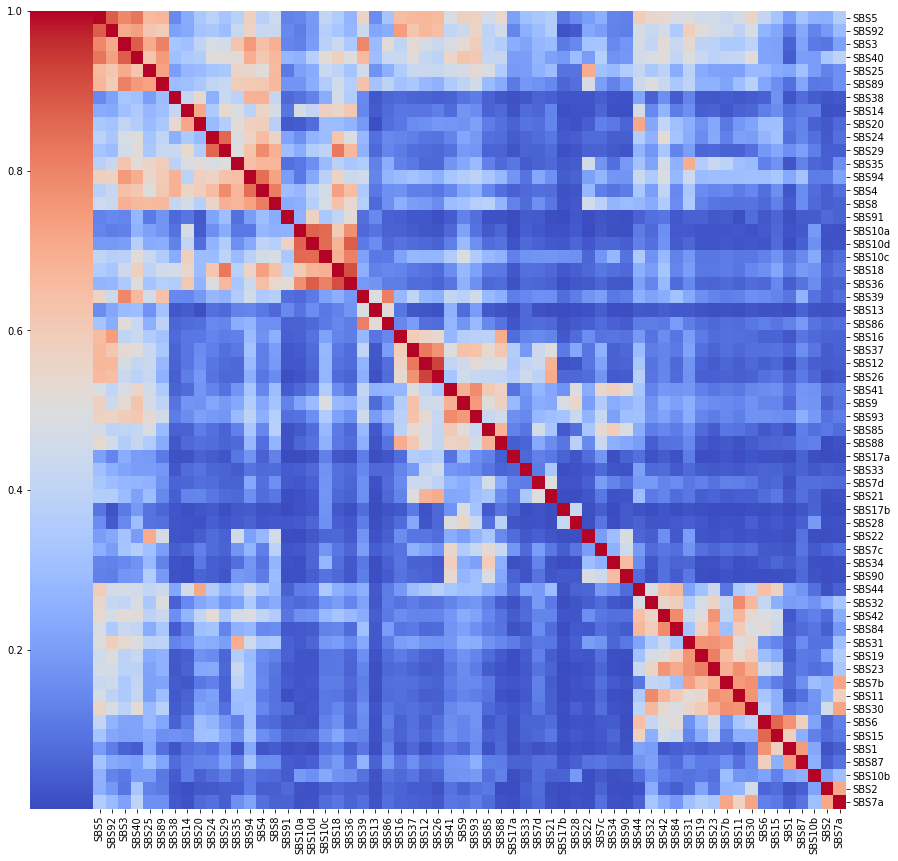

In [6]:
# clustermap

g=sns.clustermap(sim,figsize=(14,20),xticklabels=True, yticklabels=True,cmap='coolwarm')
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
# Adjust to have the column labels not cut out
plt.subplots_adjust(bottom=0.3)
g.ax_row_dendrogram.set_visible(False)
# Use the dendrogram box to reposition the colour bar
dendro_box = g.ax_row_dendrogram.get_position()
dendro_box.x0 = (dendro_box.x0 + 2 * dendro_box.x1) / 3
g.cax.set_position(dendro_box)
# Move the ticks to the left 
g.cax.yaxis.set_ticks_position("left")

In [7]:
# signature list = > 0.8

dictionaire={}

for column in COSMIC_sig.iloc[:,1:].columns:
    for column_2 in COSMIC_sig.iloc[:,1:].columns:
        s_1=COSMIC_sig[column].ravel().reshape(1,-1)
        s_2=COSMIC_sig[column_2].ravel().reshape(1,-1)
        cos=cosine_similarity(s_1,s_2)
        if column!=column_2 and cos>=0.8:
            dictionaire[str(cos[0][0])]=[column,column_2]

dfs=[]
for key in set(dictionaire.keys()):
    df=pd.DataFrame(dictionaire[key]).T
    df['similarity']=float(key)
    df.columns=['sig1','sig2','similarity']
    dfs.append(df)
    
pd.concat(dfs).sort_values(by='similarity',ascending=False).reset_index(drop=True)

,sig1,sig2,similarity
0,SBS26,SBS12,0.928396
1,SBS36,SBS18,0.908414
2,SBS92,SBS5,0.882263
3,SBS40,SBS3,0.882181
4,SBS36,SBS10d,0.880652
5,SBS10d,SBS10a,0.867596
6,SBS15,SBS6,0.861091
7,SBS29,SBS24,0.859592
8,SBS10c,SBS10a,0.857110
9,SBS10d,SBS10c,0.852706


# ARCHETYPAL ANALYSIS

Extracting archetypes in range(1,40) and select n_archetypes with 95% of the explained variance

In [8]:
var_rss=[]

print('Extracting Archetypes ...')
for n_arch in range(1,40):
    AA = ArchetypalAnalysis(n_archetypes = n_arch,
                        initialize = 'random',
                        redundancy_try = 30,
                        tolerance = 0.0001,
                        max_iter = 500,
                        random_state = 45, C = 1),
    AA.fit(np.array(COSMIC_sig.iloc[:,1:]).T)
    var_rss.append(AA.explained_variance_)

Extracting Archetypes ...


Plot the explained variance vs number of archetypes

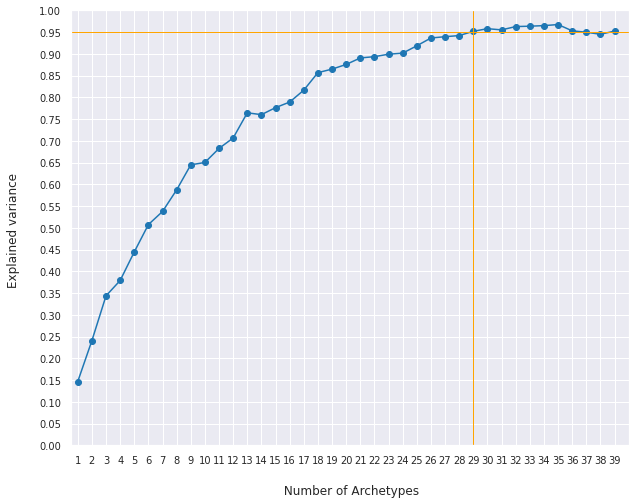

In [9]:
sns.set(font_scale=.9)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8),sharex=True)

ax1.plot(range(1, 40), var_rss,'bo-',color='tab:blue')
ax1.set_xlabel('\n Number of Archetypes',fontsize=12)
ax1.set_ylabel('Explained variance \n',fontsize=12) 
plt.xticks(np.arange(1,40))
plt.yticks(np.arange(0,1.05,0.05))
ax1.set_ylim(0.,1.0)
ax1.set_xlim(0.5,40);ax1.axvline(29,0,1,color='orange',linestyle='-',lw=1.)
ax1.axhline(0.95,0,1,color='orange',linestyle='-',lw=1.);

Perform AA with 29 latent vectors

In [10]:
AA = ArchetypalAnalysis(n_archetypes = 29,
                        initialize = 'random',
                        redundancy_try = 30,
                        tolerance = 0.0001,
                        max_iter = 500,
                        random_state = 45, C = 1),

AA.fit(np.array(COSMIC_sig.iloc[:,1:].T))

print('Residual error : ', AA.RSS_2)

Residual error :  0.3102952171216791


Plot the AA simplex

In [11]:
contrib=pd.DataFrame(AA.alfa.T)
contrib.set_index(COSMIC_sig.iloc[:,1:].columns,inplace=True)
contrib.columns=['A'+str(num) for num in range(1,AA.archetypes.shape[1]+1)]
corr = pd.melt(contrib.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

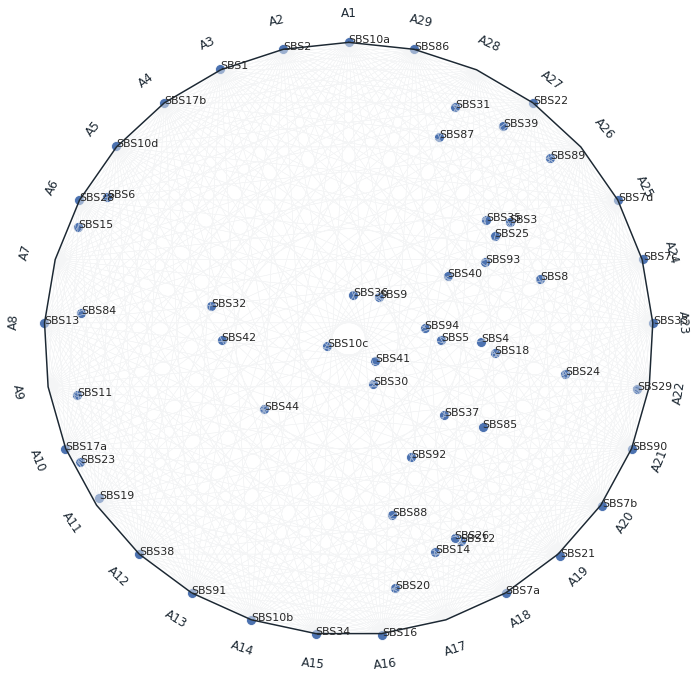

In [12]:
sns.set_style('dark')

fig,ax=create_simplex_ax(AA, grid_on = False, 
                  gridcolor = '#EAECEE', 
                  bordercolor='#1C2833', 
                  fontcolor = '#1C2833',
                  fig_size=[12,12])

mapped_alfa = map_alfa_to_simplex(AA.alfa, AA)
alfas=pd.DataFrame(mapped_alfa)
alfas.index=contrib.index

for i, txt in enumerate(list(alfas.index)):
    ax.annotate(txt,(alfas.loc[txt][0],alfas.loc[txt][1]),fontsize=11)


sns.scatterplot(mapped_alfa[:,0],mapped_alfa[:,1],s=100);

Clustermap of the Archetypes contribution in Signature reconstruction

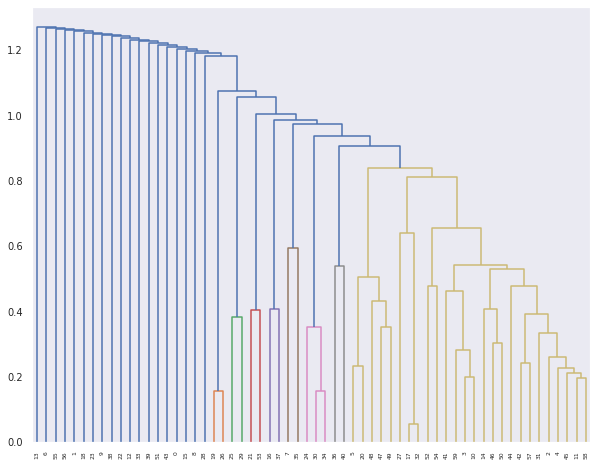

In [13]:
# dendrogram for indexing

from scipy.cluster import hierarchy

temp = hierarchy.linkage(contrib, 'average')

plt.figure(figsize=(10,8))
 
dn = hierarchy.dendrogram(temp)

In [14]:
# set color and reoredering index

a=["#F3FAFF"]*19
b=['tab:blue','tab:blue','tab:purple','tab:purple','tab:red','tab:red','tab:orange','tab:orange','tab:olive','tab:olive','darksalmon','darksalmon','darksalmon'
   ,'tab:gray','tab:gray',"dodgerblue","dodgerblue","dodgerblue","dodgerblue","dodgerblue",'lightpink','lightpink','lightpink', 'maroon','maroon'
  ,"tab:green","tab:green","tab:green","tab:green","#F3FAFF","#F3FAFF","#F3FAFF",
   "#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB","#E7EAEB"]
a.extend(b)

reordered=contrib.reset_index().loc[dn['leaves']].set_index('index')
reordered['colors']=a

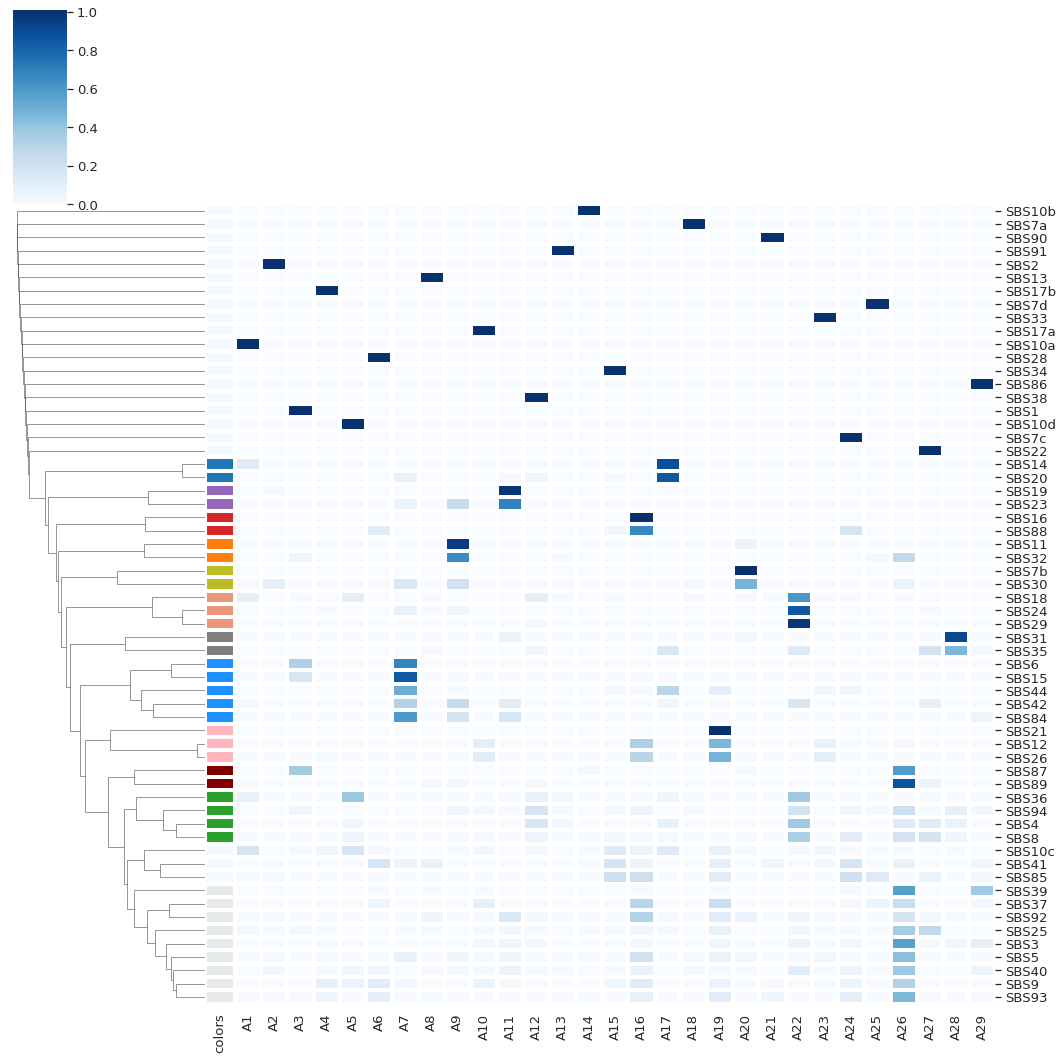

In [15]:
sns.set(font_scale=1.2)
cg=sns.clustermap(contrib, vmin=0,linewidth=4,col_cluster=False,row_cluster=True,row_colors=reordered['colors'],metric='euclidean', figsize=(15,15),xticklabels=True, yticklabels=True,cmap='Blues')
cg.ax_col_dendrogram.set_visible(False)
plt.annotate('G1',xytext=(2,0.2),xy=(2,0.2));

Plot signature reconstruction with archetypes

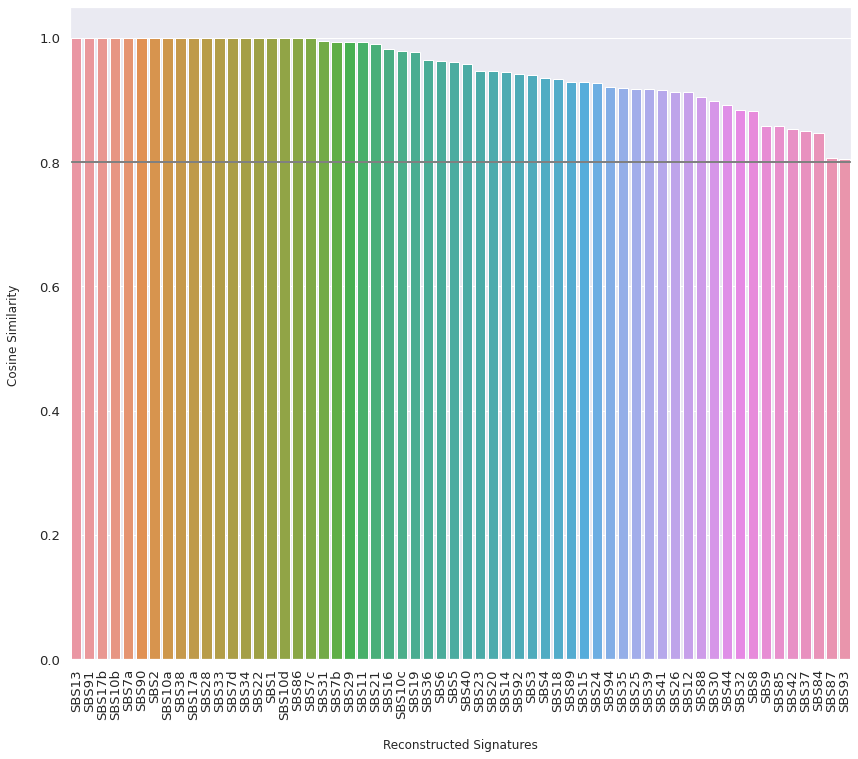

In [16]:
sns.set(font_scale=1.2)
Rec_Sig= pd.DataFrame(AA.archetypes @ AA.alfa)
Rec_Sig.columns=COSMIC_sig.iloc[:,1:].columns
rec_profiles=[]
for column in COSMIC_sig.iloc[:,1:].columns:
    s1=Rec_Sig[column].ravel().reshape(1,-1)
    s2=COSMIC_sig[column].ravel().reshape(1,-1)
    rec_profiles.append(cosine_similarity(s1,s2)[0][0])

import seaborn as sns

plt.figure(figsize=(14,12))
rec_profiles=pd.DataFrame(rec_profiles)
rec_profiles.columns=['Cosine Similarity']
rec_profiles['Reconstructed Signature']=COSMIC_sig.iloc[:,1:].columns
rec_profiles.sort_values(by='Cosine Similarity',inplace=True,ascending=False)
sns.barplot(x=rec_profiles['Reconstructed Signature'],y=rec_profiles['Cosine Similarity'])
plt.axhline(0.8,0,1,color='gray',linestyle='-',lw=2.)
plt.xlabel('\nReconstructed Signatures',fontsize=12)
plt.ylabel('Cosine Similarity \n',fontsize=12)
plt.xticks(rotation=90);

Relationship among archetypes and signatures

In [17]:
arch=pd.DataFrame(AA.archetypes)
arch.columns=['ARCH_'+str(num) for num in range(1,AA.archetypes.shape[1]+1)]
dictionaire={}
for column in COSMIC_sig.iloc[:,1:].columns:
    for column_2 in arch.columns:
        s_1=COSMIC_sig[column].ravel().reshape(1,-1)
        s_2=arch[column_2].ravel().reshape(1,-1)
        cos=cosine_similarity(s_1,s_2)
        if column!=column_2 and cos>0.8:
            dictionaire[str(cos[0][0])]=[column,column_2]
            
dfs=[]
for key in set(dictionaire.keys()):
    df=pd.DataFrame(dictionaire[key]).T
    df['similarity']=float(key)
    df.columns=['sig1','sig2','similarity']
    dfs.append(df)
    
df=pd.concat(dfs).sort_values(by='similarity',ascending=False).reset_index(drop=True)

In [18]:
df.columns=['Signatures','Archetypes','Similarity']

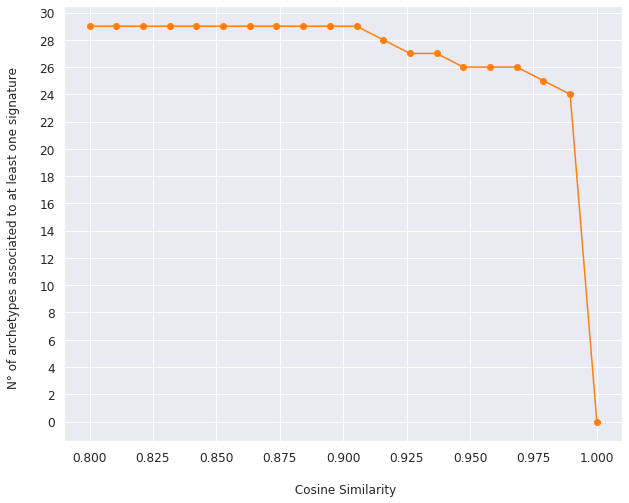

In [19]:
r_=[]
f_rec=[]
thresholds=np.linspace(0.8,1,20)

for threshold in thresholds:
    
    pure_sig=df[df['Similarity']>threshold]
    
    p=(pure_sig.iloc[:,:-1].Archetypes.value_counts()>=1)
    r=len(p[p==True])
    r_.append(r)
        
    f_rec.append(len(rec_profiles[rec_profiles['Cosine Similarity']>threshold]))


sns.set_style('dark')
sns.set(font_scale=1.1)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8),sharex=True)

ax1.plot(thresholds, r_,'bo-',color='tab:orange')

ax1.yaxis.set_ticks(np.arange(0,32,2))
ax1.set_ylabel('N° of archetypes associated to at least one signature  \n',fontsize=12) 
ax1.set_xlabel('\n Cosine Similarity',fontsize=12);

Archetypes profiles

In [20]:
def plot_archetypes(array,label, ylim=1, ax=ax,archetypes=0):
    color = ((0.196,0.714,0.863),)*16 + ((0.102,0.098,0.098),)*16 + ((0.816,0.180,0.192),)*16 + ((0.777,0.773,0.757),)*16 + ((0.604,0.777,0.408),)*16 + ((0.902,0.765,0.737),)*16
    color = list(color)
   
    width = max(array.shape)
    x = np.arange(width)
    if ax == None:
        f,ax = plt.subplots(1,figsize=(20,10))
    bars = ax.bar(x, array)

    for h in range(len(x)):
        bars[h].set_color(color[h])

        
    plt.title('Archetypes '+str(archetypes+1))
    plt.ylim(0, ylim)
    plt.xlim(0, width)

COSMIC_sig=pd.read_csv('./Utils/COSMIC_SBS_GRCh37.txt',sep='\t') 
arch.index=COSMIC_sig['Type']

In [21]:
# reindex

index=['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T',
       'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T',
       'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T',
       'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T',
       'A[C>G]A', 'A[C>G]C','A[C>G]G', 'A[C>G]T',
       'C[C>G]A', 'C[C>G]C','C[C>G]G', 'C[C>G]T',
       'G[C>G]A', 'G[C>G]C','G[C>G]G', 'G[C>G]T',
       'T[C>G]A', 'T[C>G]C','T[C>G]G', 'T[C>G]T',
       'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T',
       'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T',
       'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T',
       'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T',
       'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T',
       'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T',
       'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T',
       'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 
       'A[T>C]A', 'A[T>C]C','A[T>C]G', 'A[T>C]T',  
       'C[T>C]A', 'C[T>C]C','C[T>C]G', 'C[T>C]T',
       'G[T>C]A', 'G[T>C]C','G[T>C]G', 'G[T>C]T',
       'T[T>C]A', 'T[T>C]C','T[T>C]G', 'T[T>C]T',
       'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T',
       'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T',
       'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T',
       'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']

In [22]:
def plot_of_plot(archetypes=range(0,29)):
    
    fig,axes=plt.subplots(6,5,figsize=(16,14),sharex=True,sharey=True)
    fig.delaxes(axes[5][4])
    fig.tight_layout()

    for archetypes,ax in zip(archetypes,axes.ravel()):

        #sns.set_style('white')
        plot_archetypes(arch.loc[index].values[:,archetypes],label=index,ax=ax,archetypes=archetypes,ylim=0.7)

        l1 = mpatches.Patch(color=(0.196,0.714,0.863), label='C>A')
        l2 = mpatches.Patch(color=(0.102,0.098,0.098), label='C>G')
        l3 = mpatches.Patch(color=(0.816,0.180,0.192), label='C>T')
        l4 = mpatches.Patch(color=(0.777,0.773,0.757), label='T>A')
        l5 = mpatches.Patch(color=(0.604,0.777,0.408), label='T>C')
        l6 = mpatches.Patch(color=(0.902,0.765,0.737), label='T>G')

    
        ax.set_title('Archetypes '+str(archetypes+1),fontsize=11)
        ax.set_xticklabels(labels=index,rotation='vertical',fontsize=3)        
        ax.xaxis.set_visible(False)
        #ax.grid(axis='y')
        
    axes.ravel()[0].legend(handles=[l1, l2, l3, l4, l5, l6],loc='upper right',fontsize=9,bbox_to_anchor=(0,0,1,1))


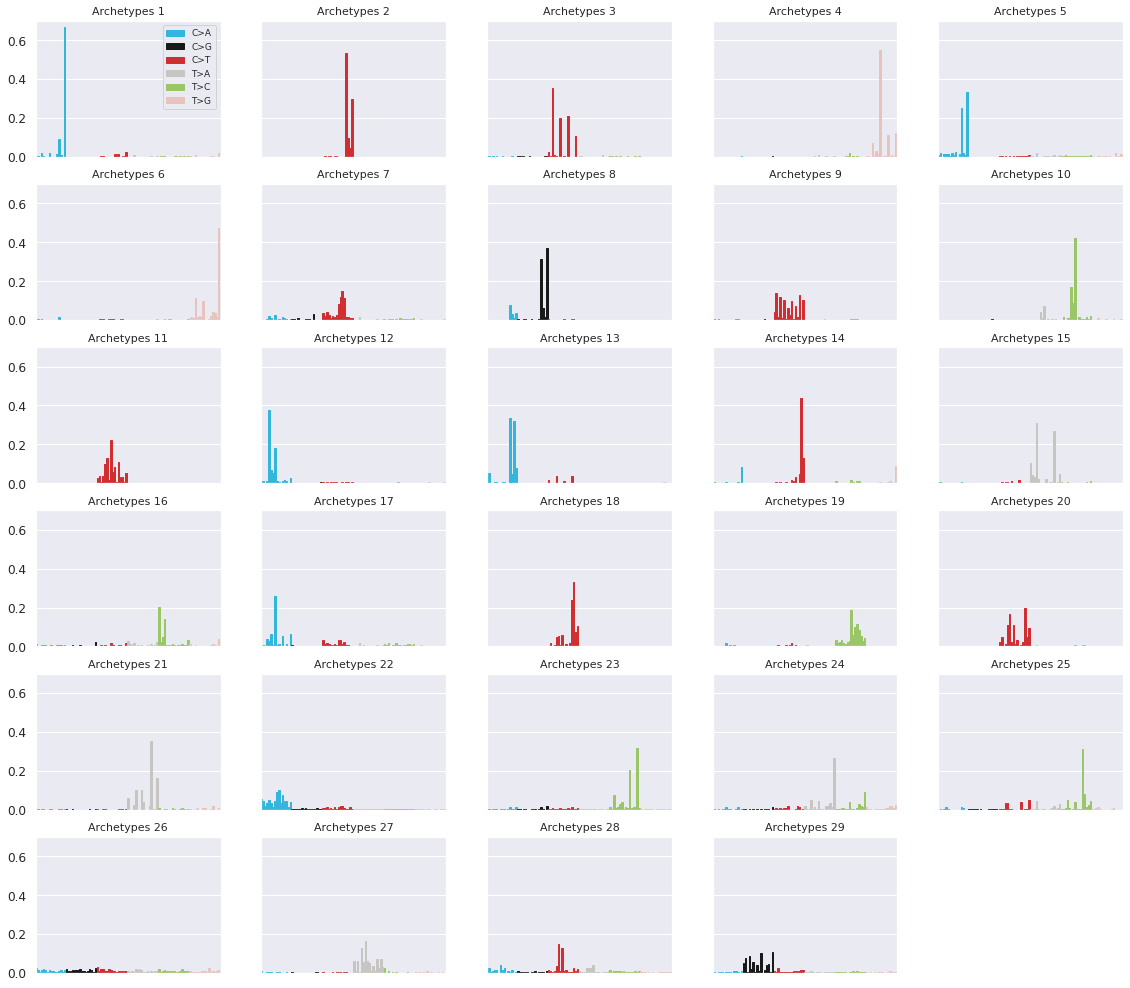

In [23]:
plot_of_plot()